# **IMPORT THE NECESSARY LIBRAIRIES**

In [ ]:
from keras.models import Sequential
import tensorflow as tf
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import  Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.layers import BatchNormalization, Dropout
import numpy as np
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
import cv2
import random
from PIL import Image
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
no_tumor = '/content/drive/MyDrive/brain_mri_detection/no'
yes_tumor = '/content/drive/MyDrive/brain_mri_detection/yes'

# Load images from folder1
no_images = []
for filename in os.listdir(no_tumor):
    if filename.endswith(".jpg"):  # Adjust the file extension as needed
        img = Image.open(os.path.join(no_tumor, filename))
        no_images.append(img)

# Load images from folder2
yes_images = []
for filename in os.listdir(yes_tumor):
    if filename.endswith(".jpg"):  # Adjust the file extension as needed
        img = Image.open(os.path.join(yes_tumor, filename))
        yes_images.append(img)


#**DATA PREPROCESSING**

In [ ]:
# Initialize variables to store the maximum width and height
max_width = 0
max_height = 0

# Iterate through images in 'no_images'
for img in no_images:
    width, height = img.size
    max_width = max(max_width, width)
    max_height = max(max_height, height)

# Iterate through images in 'yes_images'
for img in yes_images:
    width, height = img.size
    max_width = max(max_width, width)
    max_height = max(max_height, height)

# Print the maximum width and height
print("Maximum Width:", max_width)
print("Maximum Height:", max_height)

Maximum Width: 1275
Maximum Height: 1427


In [ ]:
print("1- Length of the list  no_images", len(no_images))
print("2- Length of list yes_images",len(yes_images))

1- Length of the list  no_images 85
2- Length of list yes_images 86


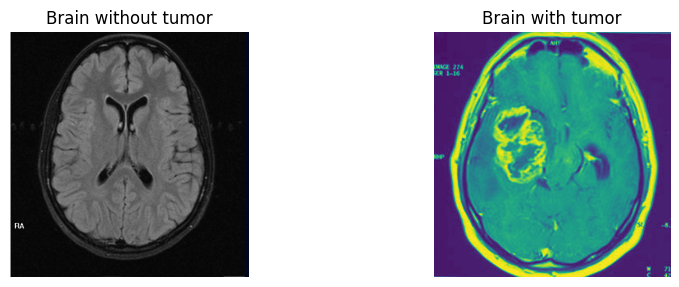

In [ ]:
fig = plt.figure(figsize=(10, 7))

# setting values to rows and column variables
rows = 2
columns = 2

# Display the first image from no_images
# Adds a subplot at the 1st position

fig.add_subplot(rows, columns, 1)

plt.axis('off')
plt.imshow(no_images[5])
plt.title("Brain without tumor")

# Display the first image from yes_images
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)

# showing image
plt.imshow(yes_images[8])
plt.axis('off')
plt.title("Brain with tumor")

plt.show()


In [ ]:
# Define image size
IMG_SIZE = 200

# Define categories
CATEGORIES = ["yes", "no"]
# Define the main directory where your images are located
main_directory = "/content/drive/MyDrive/brain_mri_detection"

# Initialize a list to store training data
training_data = []

# Load and resize images
for category in CATEGORIES:
    path = os.path.join(main_directory, category)
    class_num = CATEGORIES.index(category)

    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img))
        new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
        training_data.append([new_array, class_num])

In [ ]:
#print the length of the dataset
len(training_data)

253

In [ ]:
#visualize one sample of training_data
training_data[252]

[array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]], dtype=uint8),
 1]

# **SHUFFLE THE TRAINING DATASET AND VISUALIZE A FEW IMAGES**

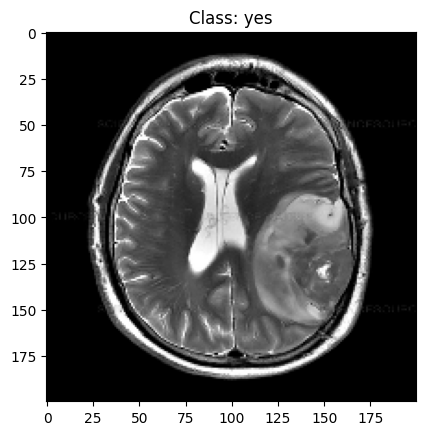

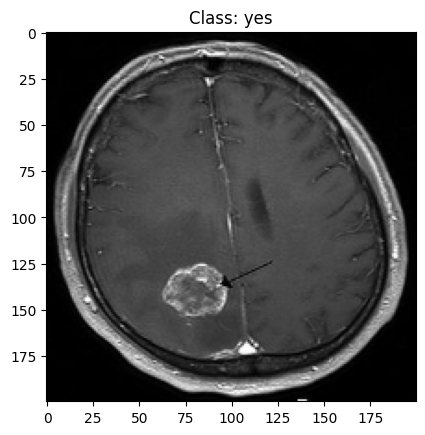

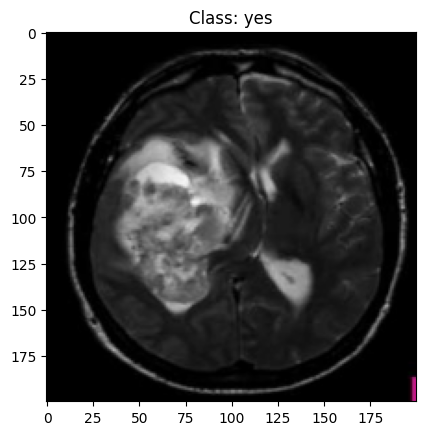

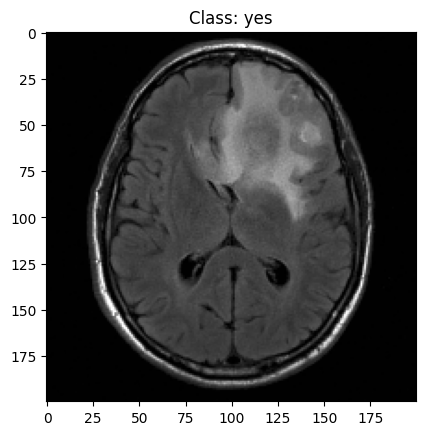

In [ ]:
# Shuffle the training data
random.shuffle(training_data)

# Visualize the first few shuffled images and their class labels
num_samples_to_display = 4
for img, class_num in training_data[:num_samples_to_display]:
    plt.figure()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert image from BGR to RGB for proper display
    plt.title(f"Class: {CATEGORIES[class_num]}")
    plt.show()

# **DATA NORMALIZATION**

In [ ]:
X = []
y = []

# Features: represent the image data
# Label: represents the corresponding label
for features, class_num in training_data:
    X.append(features)
    y.append(class_num)  # Append the class_num directly

    # Check the mapping of class_num
    #print(f"Category: {CATEGORIES[class_num]}, Numerical Value: {class_num}")
    """it will print like this
    Category: yes, Numerical Value: 0
    Category: no, Numerical Value: 1
    Category: no, Numerical Value: 1..."""

# Convert the list of image features X into a NumPy array and reshape it into a 4D array
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

# Convert the data type of the elements in the NumPy array X to float32
# Deep learning models often require input data to be in a specific data type for compatibility with Neural Networks
X = X.astype('float32')

# Data normalization to scale pixel values to the range [0, 1]
X /= 255

# No need for one-hot encoding in binary classification, use the original labels directly
y = np.array(y)



#**CNN_FUNCTION (BASIC CNN + ADDITIONAL LAYERS + HYPERPARAMETERS )**

In [ ]:
def build_cnn_model(input_shape=(200, 200, 3), hyperparameters=None):
    model = tf.keras.Sequential()

    # Convolutional layers
    model.add(tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=2))

    model.add(tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=2))

    # Add additional layers based on hyperparameters
    if hyperparameters:
        # Add Dropout layer if specified
        if hyperparameters.get('use_dropout', False):
            model.add(Dropout(hyperparameters['dropout_rate']))

        # Add BatchNormalization layer if specified
        if hyperparameters.get('use_batch_norm', False):
            model.add(BatchNormalization())

        # Additional layers you can experiment with
        if hyperparameters.get('use_additional_layer', False):
            model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
            model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=2))

            model.add(tf.keras.layers.Flatten())
            model.add(tf.keras.layers.Dense(256, activation='relu'))

    # Flatten and Dense layers
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))

    # Output layer
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    return model



# **TRAIN AND EVALUATION MODEL FUNCTION**

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

def train_and_evaluate_model(X_train, y_train, X_val, y_val, X_test, y_test, hyperparameters):
    model = build_cnn_model(hyperparameters=hyperparameters)

    model.compile(optimizer=hyperparameters.get('optimizer', 'adam'),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Set seed for reproducibility
    seed_value = 42
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)

    # Define a ModelCheckpoint callback to save the best model based on validation accuracy
    checkpoint_filepath = 'best_model.h5'
    model_checkpoint = ModelCheckpoint(checkpoint_filepath, save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

    # Define an EarlyStopping callback to stop training when the validation accuracy stops improving
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

    # Train the model and use the ModelCheckpoint callback
    epochs_hist = model.fit(X_train, y_train, batch_size=16, epochs=30, validation_data=(X_val, y_val), verbose=1, callbacks=[model_checkpoint, early_stopping])

    # Load the best model
    best_model = tf.keras.models.load_model(checkpoint_filepath)

    # Evaluate the best model on the test set
    test_metrics = best_model.evaluate(X_test, y_test)

    # Return the best model and its test metrics
    return best_model, test_metrics


In [ ]:
# Set seed for reproducibility
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

#split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=seed_value)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed_value)

# **TRY DIFFERENT EXAMPLES**

In [ ]:

# Set seed for reproducibility
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
# Example hyperparameters for the first set of experiments
hyperparameters1 = {'dropout_rate': 0.5, 'use_batch_norm': True, 'optimizer': 'adam', 'use_additional_layer': True}
best_model1, test_metrics1 = train_and_evaluate_model(X_train, y_train, X_val, y_val, X_test, y_test, hyperparameters1)

# Example with different hyperparameters for the second set of experiments
hyperparameters2 = {'use_dropout': True, 'dropout_rate': 0.3, 'optimizer': 'sgd'}
best_model2, test_metrics2 = train_and_evaluate_model(X_train, y_train, X_val, y_val, X_test, y_test, hyperparameters2)

# Example with different hyperparameters for the third set of experiments
hyperparameters3 = {'use_dropout': False, 'use_batch_norm': False, 'optimizer': 'rmsprop'}
best_model3, test_metrics3 = train_and_evaluate_model(X_train, y_train, X_val, y_val, X_test, y_test, hyperparameters3)


# Print or use the results as needed
print("Results for hyperparameters set 1:")
print(f"Test Accuracy: {test_metrics1[1]}")

print("\nResults for hyperparameters set 2:")
print(f"Test Accuracy: {test_metrics2[1]}")

print("\nResults for hyperparameters set 3:")
print(f"Test Accuracy: {test_metrics3[1]}")


Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 4.1888 - accuracy: 0.5891
Epoch 1: val_accuracy improved from -inf to 0.76000, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 18s 1s/step - loss: 4.1888 - accuracy: 0.5891 - val_loss: 0.6314 - val_accuracy: 0.7600
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.7503 - accuracy: 0.7277
Epoch 2: val_accuracy did not improve from 0.76000
13/13 [==============================] - 15s 1s/step - loss: 0.7503 - accuracy: 0.7277 - val_loss: 0.6521 - val_accuracy: 0.7600
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.2871 - accuracy: 0.8812
Epoch 3: val_accuracy improved from 0.76000 to 0.80000, saving model to best_model.h5
13/13 [==============================] - 13s 1s/step - loss: 0.2871 - accuracy: 0.8812 - val_loss: 0.6620 - val_accuracy: 0.8000
Epoch 4/30
13/13 [==============================] - ETA: 0s - loss: 0.2055 - accuracy: 0.9455
Epoch 4: val_accuracy did not improve from 0.80000
13/13 [==============================] - 18s 1s/step - loss: 0.2055 - accuracy: 0.9455 - val_loss: 0.6470 - val_accuracy: 0.8000
Epoch 5/30
13/

In [ ]:
best_model1.save("best_model1.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Set seed for reproducibility
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
# Example with different hyperparameters for the third set of experiments
hyperparameters4 = {'use_dropout': True, 'dropout_rate': 0.3,'use_batch_norm': True, 'optimizer': 'adam'}
best_model4, test_metrics4 = train_and_evaluate_model(X_train, y_train, X_val, y_val, X_test, y_test, hyperparameters4)

# Example with different hyperparameters for the third set of experiments
hyperparameters5 = {'use_dropout': True, 'dropout_rate': 0.3,'use_batch_norm': True, 'optimizer': 'adam','use_additional_layer': True}
best_model5, test_metrics5 = train_and_evaluate_model(X_train, y_train, X_val, y_val, X_test, y_test, hyperparameters5)

# Print or use the results as needed
print("Results for hyperparameters set 4:")
print(f"Test Accuracy: {test_metrics4[1]}")

print("\nResults for hyperparameters set 5:")
print(f"Test Accuracy: {test_metrics5[1]}")



Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 2.5763 - accuracy: 0.6733
Epoch 1: val_accuracy improved from -inf to 0.60000, saving model to best_model.h5
13/13 [==============================] - 15s 1s/step - loss: 2.5763 - accuracy: 0.6733 - val_loss: 0.6100 - val_accuracy: 0.6000
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.3697 - accuracy: 0.8614
Epoch 2: val_accuracy improved from 0.60000 to 0.64000, saving model to best_model.h5
13/13 [==============================] - 11s 876ms/step - loss: 0.3697 - accuracy: 0.8614 - val_loss: 0.6467 - val_accuracy: 0.6400
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.1710 - accuracy: 0.9406
Epoch 3: val_accuracy improved from 0.64000 to 0.84000, saving model to best_model.h5
13/13 [==============================] - 14s 1s/step - loss: 0.1710 - accuracy: 0.9406 - val_loss: 0.6202 - val_accuracy: 0.8400
Epoch 4/30
13/13 [==============================] - ETA: 0s - loss: 0.110

In [ ]:
best_model4.save("best_model4.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Set seed for reproducibility
seed_value = 42
np.random.seed(seed_value)
# Example with different hyperparameters for the third set of experiments
hyperparameters6 = {'use_dropout': True,'dropout_rate': 0.5, 'use_batch_norm': True, 'optimizer': 'rmsprop'}
best_model6, test_metrics6 = train_and_evaluate_model(X_train, y_train, X_val, y_val, X_test, y_test, hyperparameters6)

# Example with different hyperparameters for the third set of experiments
hyperparameters7 = {'use_dropout': True,'dropout_rate': 0.3, 'use_batch_norm': True, 'optimizer': 'rmsprop'}
best_model7, test_metrics7 = train_and_evaluate_model(X_train, y_train, X_val, y_val, X_test, y_test, hyperparameters7)

# Print or use the results as needed
print("Results for hyperparameters set 6:")
print(f"Test Accuracy: {test_metrics6[1]}")

print("Results for hyperparameters set 7:")
print(f"Test Accuracy: {test_metrics7[1]}")

Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 3.9148 - accuracy: 0.6733
Epoch 1: val_accuracy improved from -inf to 0.60000, saving model to best_model.h5
13/13 [==============================] - 15s 1s/step - loss: 3.9148 - accuracy: 0.6733 - val_loss: 1.4999 - val_accuracy: 0.6000
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.4913 - accuracy: 0.7822
Epoch 2: val_accuracy improved from 0.60000 to 0.68000, saving model to best_model.h5
13/13 [==============================] - 13s 991ms/step - loss: 0.4913 - accuracy: 0.7822 - val_loss: 0.7450 - val_accuracy: 0.6800
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.2575 - accuracy: 0.8713
Epoch 3: val_accuracy improved from 0.68000 to 0.80000, saving model to best_model.h5
13/13 [==============================] - 12s 847ms/step - loss: 0.2575 - accuracy: 0.8713 - val_loss: 0.6052 - val_accuracy: 0.8000
Epoch 4/30
13/13 [==============================] - ETA: 0s - loss: 0.

In [ ]:
# Display model summary for hyperparameters1
print("Model Summary for hyperparameters set 1:")
best_model1.summary()
print("Model Summary for hyperparameters set 2:")
best_model2.summary()
print("Model Summary for hyperparameters set 3:")
best_model3.summary()
print("Model Summary for hyperparameters set 4:")
best_model4.summary()
print("Model Summary for hyperparameters set 5:")
best_model5.summary()
print("Model Summary for hyperparameters set 6:")
best_model6.summary()
print("Model Summary for hyperparameters set 7:")
best_model7.summary()

Model Summary for hyperparameters set 1:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 200, 200, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 100, 100, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 100, 100, 32)      9248      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 50, 50, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization_1 (Bat  (None, 50, 50, 32)        128       
 chNormalization)                                                
             

# **PLOT CONFUSION MATRIX FOR EACH EXAMPLE**

1/1 [==============================] - 1s 649ms/step


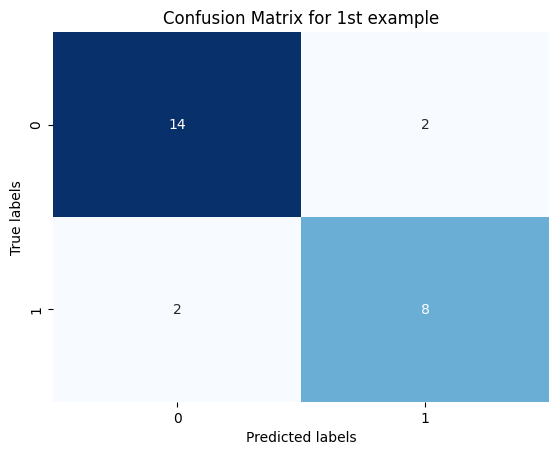

1/1 [==============================] - 1s 764ms/step


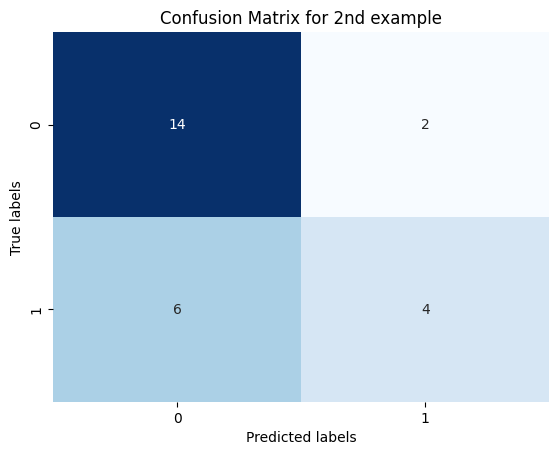

1/1 [==============================] - 1s 788ms/step


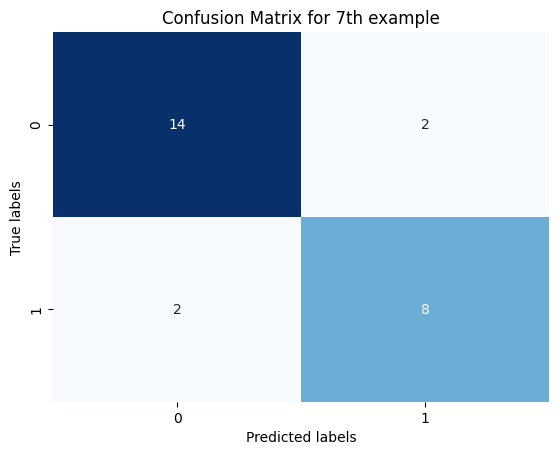

In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, labels, title):
  # Set seed for reproducibility
    seed_value = 42
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    cm = confusion_matrix(y_true, y_pred)
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', cbar=False)

    # labels, title, and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)

    # Set the title for this confusion matrix
    ax.set_title(title)

    plt.show()

# Set seed for reproducibility
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# Assuming you have binary classification (0 and 1)
class_labels = [0, 1]

# Confusion matrix for hyperparameters1
y_pred1 = best_model1.predict(X_test)
y_pred1_binary = np.round(y_pred1).astype(int)
plot_confusion_matrix(y_test, y_pred1_binary, class_labels, 'Confusion Matrix for 1st example')

# Confusion matrix for hyperparameters2
y_pred2 = best_model2.predict(X_test)
y_pred2_binary = np.round(y_pred2).astype(int)
plot_confusion_matrix(y_test, y_pred2_binary, class_labels, 'Confusion Matrix for 2nd example')

# Confusion matrix for hyperparameters7
y_pred7 = best_model7.predict(X_test)
y_pred7_binary = np.round(y_pred7).astype(int)
plot_confusion_matrix(y_test, y_pred7_binary, class_labels, 'Confusion Matrix for 7th example')

# yes==0
# no==1


In [ ]:
from sklearn.metrics import classification_report

# Set seed for reproducibility
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# Example with different hyperparameters for the first set of experiments
y_pred1 = best_model1.predict(X_test)
y_pred1_binary = np.round(y_pred1).astype(int)
# Display classification report for hyperparameters1
print("Classification Report for hyperparameters set 1:")
print(classification_report(y_test, y_pred1_binary))

# Example with different hyperparameters for the second set of experiments
y_pred2 = best_model2.predict(X_test)
y_pred2_binary = np.round(y_pred2).astype(int)
# Display classification report for hyperparameters2
print("\nClassification Report for hyperparameters set 2:")
print(classification_report(y_test, y_pred2_binary))

# Example with different hyperparameters for the second set of experiments
y_pred3 = best_model3.predict(X_test)
y_pred3_binary = np.round(y_pred3).astype(int)
# Display classification report for hyperparameters2
print("\nClassification Report for hyperparameters set 3:")
print(classification_report(y_test, y_pred3_binary))

# Example with different hyperparameters for the second set of experiments
y_pred4 = best_model4.predict(X_test)
y_pred4_binary = np.round(y_pred4).astype(int)
# Display classification report for hyperparameters2
print("\nClassification Report for hyperparameters set 4:")
print(classification_report(y_test, y_pred4_binary))

# Example with different hyperparameters for the second set of experiments
y_pred5 = best_model5.predict(X_test)
y_pred5_binary = np.round(y_pred2).astype(int)
# Display classification report for hyperparameters2
print("\nClassification Report for hyperparameters set 5:")
print(classification_report(y_test, y_pred5_binary))

# Example with different hyperparameters for the second set of experiments
y_pred6 = best_model6.predict(X_test)
y_pred6_binary = np.round(y_pred6).astype(int)
# Display classification report for hyperparameters2
print("\nClassification Report for hyperparameters set 6:")
print(classification_report(y_test, y_pred6_binary))


# Example with different hyperparameters for the third set of experiments
y_pred7 = best_model7.predict(X_test)
y_pred7_binary = np.round(y_pred7).astype(int)
# Display classification report for hyperparameters7
print("\nClassification Report for hyperparameters set 7:")
print(classification_report(y_test, y_pred7_binary))


1/1 [==============================] - 1s 962ms/step
Classification Report for hyperparameters set 1:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        16
           1       0.80      0.80      0.80        10

    accuracy                           0.85        26
   macro avg       0.84      0.84      0.84        26
weighted avg       0.85      0.85      0.85        26

1/1 [==============================] - 1s 1s/step

Classification Report for hyperparameters set 2:
              precision    recall  f1-score   support

           0       0.70      0.88      0.78        16
           1       0.67      0.40      0.50        10

    accuracy                           0.69        26
   macro avg       0.68      0.64      0.64        26
weighted avg       0.69      0.69      0.67        26

1/1 [==============================] - 1s 813ms/step

Classification Report for hyperparameters set 3:
              precision    recall  f1-sco

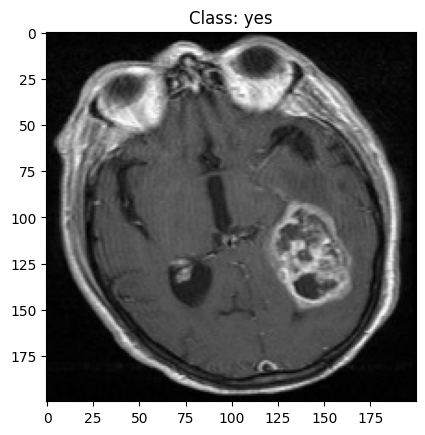

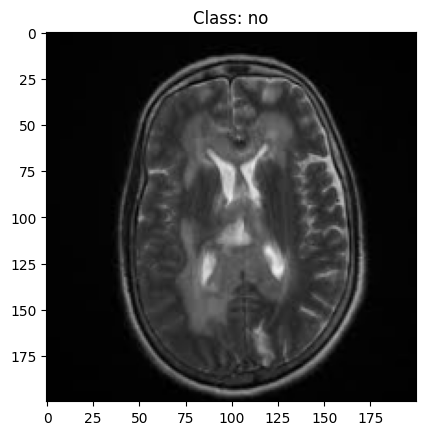

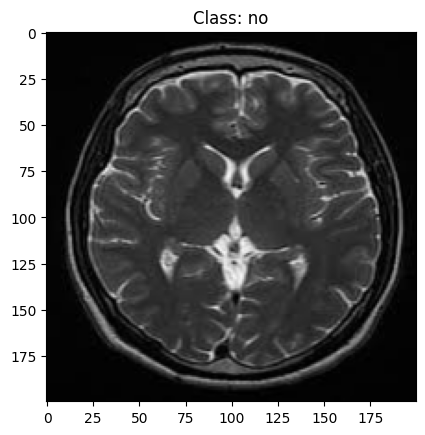

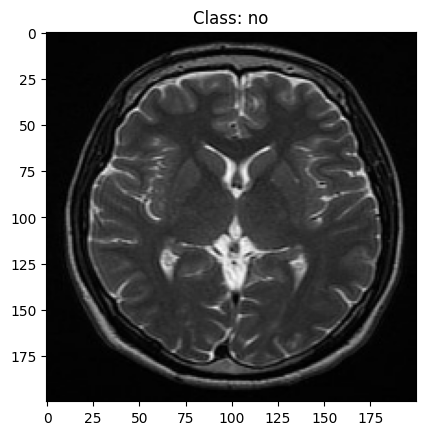

In [ ]:
# Set seed for reproducibility
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
# Create an ImageDataGenerator with desired augmentations
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Shuffle the training data before applying augmentation
random.shuffle(training_data)

# Visualize the first few shuffled images and their class labels
num_samples_to_display = 4
for img, class_num in training_data[:num_samples_to_display]:
    plt.figure()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"Class: {CATEGORIES[class_num]}")
    plt.show()

# Initialize empty lists to store augmented data
augmented_X = []
augmented_y = []

# Apply data augmentation and append to lists
for features, class_num in training_data:
    # Reshape image to (1, height, width, channels)
    img = features.reshape((1,) + features.shape)

    # Generate augmented images
    augmented_images = datagen.flow(img, batch_size=1)

    # Append augmented images to the lists
    for i in range(5):
        augmented_image = augmented_images.next()[0].astype('uint8')

        # Resize augmented image to the desired dimensions
        augmented_image = cv2.resize(augmented_image, (200, 200))

        augmented_X.append(augmented_image)
        augmented_y.append(class_num)

# Convert the augmented data to NumPy arrays
augmented_X = np.array(augmented_X)
augmented_y = np.array(augmented_y)

# Shuffle the augmented data
augmented_X, augmented_y = shuffle(augmented_X, augmented_y)

# Append the augmented data to the original data
X = np.concatenate([X, augmented_X], axis=0)
y = np.concatenate([y, augmented_y], axis=0)

In [ ]:
X.shape

(1518, 200, 200, 3)

In [ ]:
y.shape

(1518,)

In [ ]:
# Set seed for reproducibility
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
# Split the augmented data into training and validation sets
X_train_aug, X_val_aug, y_train_aug, y_val_aug = train_test_split(augmented_X, augmented_y, test_size=0.2, random_state=42)

# Combine the original and augmented training sets
X_train_combined = np.concatenate([X_train, X_train_aug], axis=0)
y_train_combined = np.concatenate([y_train, y_train_aug], axis=0)

# Combine the original and augmented validation sets
X_val_combined = np.concatenate([X_val, X_val_aug], axis=0)
y_val_combined = np.concatenate([y_val, y_val_aug], axis=0)

# Example hyperparameters for the combined training set
hyperparameters_combined = {'dropout_rate': 0.5, 'use_batch_norm': True, 'optimizer': 'adam', 'use_additional_layer': True}
best_model_combined, test_metrics_combined = train_and_evaluate_model(X_train_combined, y_train_combined, X_val_combined, y_val_combined, X_test, y_test, hyperparameters_combined)

# Print or use the results as needed
print("Results for the combined training set:")
print(f"Test Accuracy: {test_metrics_combined[1]}")


Epoch 1/30
140/140 [==============================] - ETA: 0s - loss: 1.2798 - accuracy: 0.6258
Epoch 1: val_accuracy improved from -inf to 0.67160, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


140/140 [==============================] - 175s 1s/step - loss: 1.2798 - accuracy: 0.6258 - val_loss: 0.6117 - val_accuracy: 0.6716
Epoch 2/30
140/140 [==============================] - ETA: 0s - loss: 0.5466 - accuracy: 0.7206
Epoch 2: val_accuracy improved from 0.67160 to 0.74568, saving model to best_model.h5
140/140 [==============================] - 167s 1s/step - loss: 0.5466 - accuracy: 0.7206 - val_loss: 0.5140 - val_accuracy: 0.7457
Epoch 3/30
140/140 [==============================] - ETA: 0s - loss: 0.4950 - accuracy: 0.7511
Epoch 3: val_accuracy improved from 0.74568 to 0.77284, saving model to best_model.h5
140/140 [==============================] - 169s 1s/step - loss: 0.4950 - accuracy: 0.7511 - val_loss: 0.5298 - val_accuracy: 0.7728
Epoch 4/30
140/140 [==============================] - ETA: 0s - loss: 0.4193 - accuracy: 0.7987
Epoch 4: val_accuracy did not improve from 0.77284
140/140 [==============================] - 159s 1s/step - loss: 0.4193 - accuracy: 0.7987 - v

In [ ]:
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
# Example hyperparameters for the combined training set (Example 2)
hyperparameters_combined_2 = {'dropout_rate': 0.3, 'use_batch_norm': False, 'optimizer': 'rmsprop', 'use_additional_layer': False}

# Example hyperparameters for the combined training set (Example 3)
hyperparameters_combined_3 = {'dropout_rate': 0.4, 'use_batch_norm': True, 'optimizer': 'adam', 'use_additional_layer': False}

# Train and evaluate the model on the combined training set for each example


best_model_combined_2, test_metrics_combined_2 = train_and_evaluate_model(
    X_train_combined, y_train_combined, X_val_combined, y_val_combined, X_test, y_test, hyperparameters_combined_2
)

best_model_combined_3, test_metrics_combined_3 = train_and_evaluate_model(
    X_train_combined, y_train_combined, X_val_combined, y_val_combined, X_test, y_test, hyperparameters_combined_3
)

# Print or use the results as needed
print("\nResults for hyperparameters_combined_2:")
print(f"Test Accuracy: {test_metrics_combined_2[1]}")

print("\nResults for hyperparameters_combined_3:")
print(f"Test Accuracy: {test_metrics_combined_3[1]}")


Epoch 1/30
140/140 [==============================] - ETA: 0s - loss: 34.9996 - accuracy: 0.6568
Epoch 1: val_accuracy improved from -inf to 0.72593, saving model to best_model.h5
140/140 [==============================] - 138s 983ms/step - loss: 34.9996 - accuracy: 0.6568 - val_loss: 0.5547 - val_accuracy: 0.7259
Epoch 2/30
140/140 [==============================] - ETA: 0s - loss: 0.6411 - accuracy: 0.7385
Epoch 2: val_accuracy did not improve from 0.72593
140/140 [==============================] - 136s 973ms/step - loss: 0.6411 - accuracy: 0.7385 - val_loss: 0.9723 - val_accuracy: 0.6790
Epoch 3/30
140/140 [==============================] - ETA: 0s - loss: 0.4389 - accuracy: 0.8185
Epoch 3: val_accuracy improved from 0.72593 to 0.75556, saving model to best_model.h5
140/140 [==============================] - 135s 962ms/step - loss: 0.4389 - accuracy: 0.8185 - val_loss: 0.7502 - val_accuracy: 0.7556
Epoch 4/30
140/140 [==============================] - ETA: 0s - loss: 0.2545 - accura

5/5 [==============================] - 2s 451ms/step


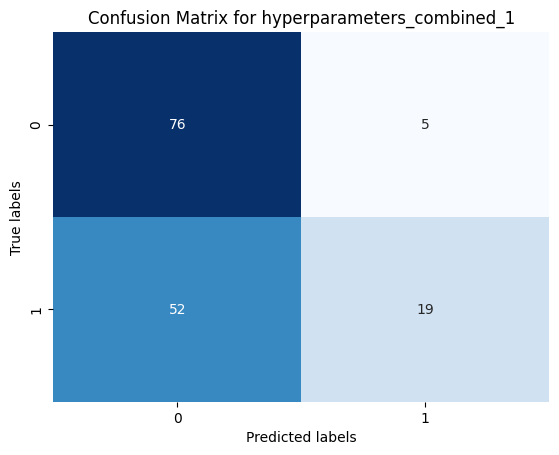

5/5 [==============================] - 2s 390ms/step


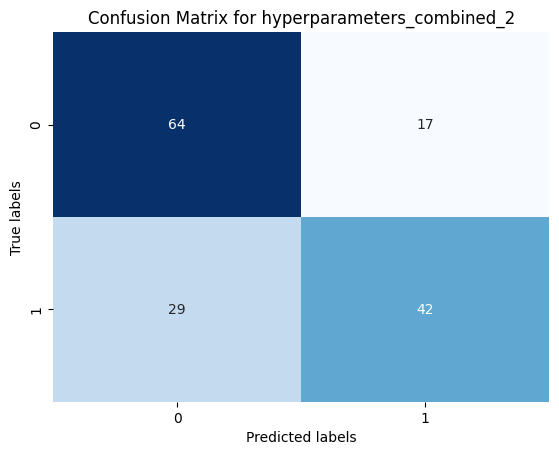

5/5 [==============================] - 2s 406ms/step


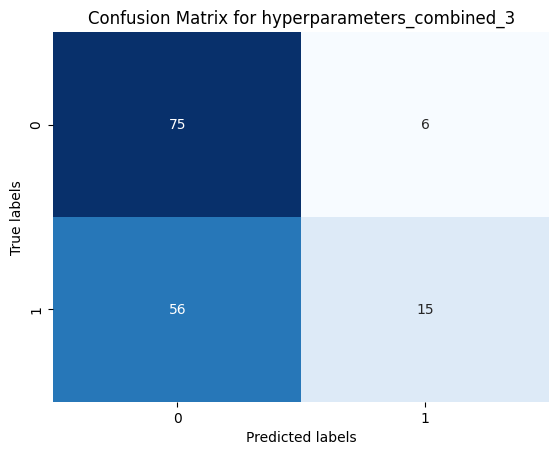

In [ ]:
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
# Assuming you have binary classification (0 and 1)
class_labels = [0, 1]

# Confusion matrix for hyperparameters_combined_1
y_pred_combined_1 = best_model_combined.predict(X_test)
y_pred_combined_1_binary = np.round(y_pred_combined_1).astype(int)
plot_confusion_matrix(y_test, y_pred_combined_1_binary, class_labels, 'Confusion Matrix for hyperparameters_combined_1')

# Confusion matrix for hyperparameters_combined_2
y_pred_combined_2 = best_model_combined_2.predict(X_test)
y_pred_combined_2_binary = np.round(y_pred_combined_2).astype(int)
plot_confusion_matrix(y_test, y_pred_combined_2_binary, class_labels, 'Confusion Matrix for hyperparameters_combined_2')

# Confusion matrix for hyperparameters_combined_3
y_pred_combined_3 = best_model_combined_3.predict(X_test)
y_pred_combined_3_binary = np.round(y_pred_combined_3).astype(int)
plot_confusion_matrix(y_test, y_pred_combined_3_binary, class_labels, 'Confusion Matrix for hyperparameters_combined_3')
# yes==0
# no==1


In [ ]:

# Set seed for reproducibility
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# Display classification report for hyperparameters_combined_1
print("\nClassification Report for hyperparameters_combined_1:")
print(classification_report(y_test, y_pred_combined_1_binary))

# Display classification report for hyperparameters_combined_2
print("\nClassification Report for hyperparameters_combined_2:")
print(classification_report(y_test, y_pred_combined_2_binary))

# Display classification report for hyperparameters_combined_3
print("\nClassification Report for hyperparameters_combined_3:")
print(classification_report(y_test, y_pred_combined_3_binary))



Classification Report for hyperparameters_combined_1:
              precision    recall  f1-score   support

           0       0.62      1.00      0.76        16
           1       0.00      0.00      0.00        10

    accuracy                           0.62        26
   macro avg       0.31      0.50      0.38        26
weighted avg       0.38      0.62      0.47        26


Classification Report for hyperparameters_combined_2:
              precision    recall  f1-score   support

           0       0.65      0.81      0.72        16
           1       0.50      0.30      0.37        10

    accuracy                           0.62        26
   macro avg       0.57      0.56      0.55        26
weighted avg       0.59      0.62      0.59        26


Classification Report for hyperparameters_combined_3:
              precision    recall  f1-score   support

           0       0.70      0.88      0.78        16
           1       0.67      0.40      0.50        10

    accuracy     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#from tensorflow.keras.models import load_model

# Load the best model
#best_model = load_model('best_model.h5')

# Now, you can use this model to make predictions on new data
#predictions = best_model.predict(new_data)


In [ ]:
X = []
y = []

# Features: represent the image data
# Label: represents the corresponding label
for features, class_num in training_data:
    X.append(features)
    y.append(class_num)  # Append the class_num directly

    # Check the mapping of class_num
    #print(f"Category: {CATEGORIES[class_num]}, Numerical Value: {class_num}")
    """it will print like this
    Category: yes, Numerical Value: 0
    Category: no, Numerical Value: 1
    Category: no, Numerical Value: 1..."""

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Assuming you have your features in X and labels in y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert lists to NumPy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)

# Flatten the image data for SVM
num_samples_train, height, width, channels = X_train.shape
X_train_flattened = X_train.reshape((num_samples_train, -1))

num_samples_test, _, _, _ = X_test.shape
X_test_flattened = X_test.reshape((num_samples_test, -1))

# It's a good practice to standardize the features for SVM
scaler = StandardScaler()

# Standardize the features
X_train_scaled = scaler.fit_transform(X_train_flattened)
X_test_scaled = scaler.transform(X_test_flattened)

# Create an SVM classifier with a linear kernel
svm_classifier = SVC(kernel='linear', random_state=42)

# Train the model
svm_classifier.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = svm_classifier.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_rep)


Accuracy: 0.7843137254901961
Confusion Matrix:
 [[24  4]
 [ 7 16]]
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.86      0.81        28
           1       0.80      0.70      0.74        23

    accuracy                           0.78        51
   macro avg       0.79      0.78      0.78        51
weighted avg       0.79      0.78      0.78        51



Best Hyperparameters: {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
Accuracy: 0.6470588235294118
Confusion Matrix:
 [[28  0]
 [18  5]]
Classification Report:
               precision    recall  f1-score   support

           0       0.61      1.00      0.76        28
           1       1.00      0.22      0.36        23

    accuracy                           0.65        51
   macro avg       0.80      0.61      0.56        51
weighted avg       0.79      0.65      0.58        51



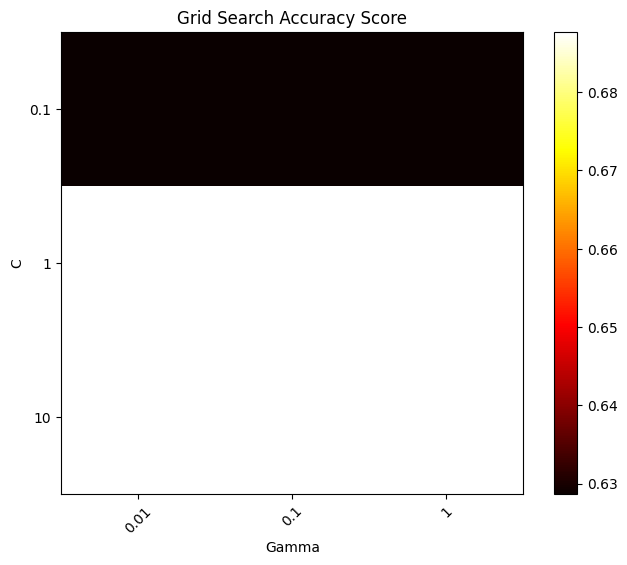

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Assuming you have your features in X and labels in y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert lists to NumPy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)

# Flatten the image data for SVM
num_samples_train, height, width, channels = X_train.shape
X_train_flattened = X_train.reshape((num_samples_train, -1))

num_samples_test, _, _, _ = X_test.shape
X_test_flattened = X_test.reshape((num_samples_test, -1))

# It's a good practice to standardize the features for SVM
scaler = StandardScaler()

# Standardize the features
X_train_scaled = scaler.fit_transform(X_train_flattened)
X_test_scaled = scaler.transform(X_test_flattened)

# Define the parameter grid for GridSearchCV
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.01, 0.1, 1],
    'kernel': ['rbf']
}

# Create an SVM classifier with an RBF kernel
svm_classifier_rbf = SVC()

# Perform GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(svm_classifier_rbf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Train the model with the best hyperparameters
best_svm_classifier = SVC(**best_params)
best_svm_classifier.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = best_svm_classifier.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Best Hyperparameters: {best_params}")
print(f"Accuracy: {accuracy}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_rep)

# Plot the results of the grid search
scores = grid_search.cv_results_['mean_test_score'].reshape(len(param_grid['C']), len(param_grid['gamma']))

plt.figure(figsize=(8, 6))
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('Gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(param_grid['gamma'])), param_grid['gamma'], rotation=45)
plt.yticks(np.arange(len(param_grid['C'])), param_grid['C'])
plt.title('Grid Search Accuracy Score')
plt.show()
